# Creating the boundary forcing

In [1]:
from roms_tools import Grid, BoundaryForcing



As always, the first step is to create our grid. Note that it is important to use the same grid throughout all the steps (i.e., creating tidal forcing, surface forcing, initial conditions, etc.) to set up a consistent ROMS simulation. Here we use the following grid.

In [2]:
grid = Grid(
    nx=100, ny=100, size_x=1800, size_y=2400, center_lon=-21, center_lat=61, rot=20
)

Next, we specify the temporal range that we want to make the surface forcing for.

In [3]:
from datetime import datetime

In [4]:
start_time = datetime(2012, 1, 2)
end_time = datetime(2012, 1, 4)

`ROMS-Tools` can create two types of boundary forcing:

* physical boundary forcing like temperature, salinity, velocities, and sea surface height
* biogeochemical (BGC) boundary forcing like alkalinity, dissolved inorganic phosphate, etc.

As with surface forcing, ROMS accepts multiple boundary forcing files, so we create these two types separately.

## Physical boundary forcing

In this section, we use GLORYS data to create our physical boundary forcing. The user is expected to have downloaded the GLORYS data spanning the desired ROMS domain and temporal range. You can download the GLORYS data from https://www.mercator-ocean.eu/en/ocean-science/glorys/. Our downloaded data sits at the following location.

In [5]:
glorys_path = [
    "/global/cfs/projectdirs/m4746/Datasets/GLORYS/NA/2012/mercatorglorys12v1_gl12_mean_20120101.nc",  # include data from day before start time, just to be safe
    "/global/cfs/projectdirs/m4746/Datasets/GLORYS/NA/2012/mercatorglorys12v1_gl12_mean_20120102.nc",
    "/global/cfs/projectdirs/m4746/Datasets/GLORYS/NA/2012/mercatorglorys12v1_gl12_mean_20120103.nc",
    "/global/cfs/projectdirs/m4746/Datasets/GLORYS/NA/2012/mercatorglorys12v1_gl12_mean_20120104.nc",
    "/global/cfs/projectdirs/m4746/Datasets/GLORYS/NA/2012/mercatorglorys12v1_gl12_mean_20120105.nc",  # include data from day after end time, just to be safe
]

Note that we could have also specified the data location via a wildcard, e.g., `path='/glade/derecho/scratch/bachman/GLORYS/NA/2012/*.nc'`. But with this latter choice, `ROMS-Tools` will operate quite a bit slower. More specific filenames are better!

We now create an instance of the `BoundaryForcing` class with `type = "physics"`.

In [6]:
%%time

boundary_forcing = BoundaryForcing(
    grid=grid,
    start_time=start_time,
    end_time=end_time,
    boundaries={
        "south": True,
        "east": True,
        "north": True,
        "west": True,
    },  # this choice is the default
    source={"name": "GLORYS", "path": glorys_path},
    type="physics",  # "physics" or "bgc"; default is "physics"
    use_dask=True,  # default is False
)

CPU times: user 6.09 s, sys: 2.85 s, total: 8.94 s
Wall time: 11.2 s


The boundary forcing variables are held in an `xarray.Dataset` that is accessible via the `.ds` property.

In [7]:
boundary_forcing.ds

<xarray.Dataset> Size: 3MB
Dimensions:     (bry_time: 4, s_rho: 100, xi_u: 101, xi_rho: 102, eta_rho: 102,
                 eta_v: 101)
Coordinates:
    abs_time    (bry_time) datetime64[ns] 32B 2012-01-01T12:00:00 ... 2012-01...
  * bry_time    (bry_time) float64 32B 4.384e+03 4.384e+03 4.386e+03 4.386e+03
Dimensions without coordinates: s_rho, xi_u, xi_rho, eta_rho, eta_v
Data variables: (12/28)
    u_south     (bry_time, s_rho, xi_u) float32 162kB dask.array<chunksize=(1, 100, 101), meta=np.ndarray>
    v_south     (bry_time, s_rho, xi_rho) float32 163kB dask.array<chunksize=(1, 100, 102), meta=np.ndarray>
    zeta_south  (bry_time, xi_rho) float32 2kB dask.array<chunksize=(1, 102), meta=np.ndarray>
    temp_south  (bry_time, s_rho, xi_rho) float32 163kB dask.array<chunksize=(1, 100, 102), meta=np.ndarray>
    salt_south  (bry_time, s_rho, xi_rho) float32 163kB dask.array<chunksize=(1, 100, 102), meta=np.ndarray>
    ubar_south  (bry_time, xi_u) float32 2kB dask.array<chunksize=(1, 101), meta=np.ndarray>
    ...          ...
    v_west      (bry_time, s_rho, eta_v) float32 162kB dask.array<chunksize=(1, 100, 101), meta=np.ndarray>
    zeta_west   (bry_time, eta_rho) float32 2kB dask.array<chunksize=(1, 102), meta=np.ndarray>
    temp_west   (bry_time, s_rho, eta_rho) float32 163kB dask.array<chunksize=(1, 100, 102), meta=np.ndarray>
    salt_west   (bry_time, s_rho, eta_rho) float32 163kB dask.array<chunksize=(1, 100, 102), meta=np.ndarray>
    ubar_west   (bry_time, eta_rho) float32 2kB dask.array<chunksize=(1, 102), meta=np.ndarray>
    vbar_west   (bry_time, eta_v) float32 2kB dask.array<chunksize=(1, 101), meta=np.ndarray>
Attributes:
    title:                 ROMS boundary forcing file created by ROMS-Tools
    roms_tools_version:    0.1.dev138+dirty
    start_time:            2012-01-02 00:00:00
    end_time:              2012-01-04 00:00:00
    source:                GLORYS
    model_reference_date:  2000-01-01 00:00:00
    theta_s:               5.0
    theta_b:               2.0
    hc:                    300.0

All physical boundary forcing fields necessary to run a ROMS simulation are now contained as `dask.arrays` within an `xarray.Dataset`. All data operations are performed lazily, meaning that the surface forcing fields have not been actually computed yet. Full computation will not be triggered until the `.save` method is called.

In [8]:
boundary_forcing.ds.bry_time

<xarray.DataArray 'bry_time' (bry_time: 4)> Size: 32B
array([4383.5, 4384.5, 4385.5, 4386.5])
Coordinates:
    abs_time  (bry_time) datetime64[ns] 32B 2012-01-01T12:00:00 ... 2012-01-0...
  * bry_time  (bry_time) float64 32B 4.384e+03 4.384e+03 4.386e+03 4.386e+03
Attributes:
    long_name:  days since 2000-01-01 00:00:00
    units:      days

The `bry_time` variable shows relative time, i.e., days since the model reference date (here set to January 1, 2000 by default). The `abs_time` coordinate shows the absolute time. The GLORYS data provided to `ROMS-Tools` has daily frequency; this temporal frequency is inherited by `boundary_forcing`. 

`boundary_forcing` has 4 time entries because `ROMS-Tools` makes sure to include one time entry at or before the `start_time`, and one time entry at or after the `end_time`. This is essential for proper functioning within ROMS. If the provided data does not meet this requirement, `ROMS-Tools` will issue a warning.

Let's make some plots! As an example, let's have a look at the zonal velocity field `u` at the southern and western boundaries.

In [9]:
from dask.diagnostics import ProgressBar

[########################################] | 100% Completed | 302.89 ms
CPU times: user 268 ms, sys: 150 ms, total: 418 ms
Wall time: 410 ms


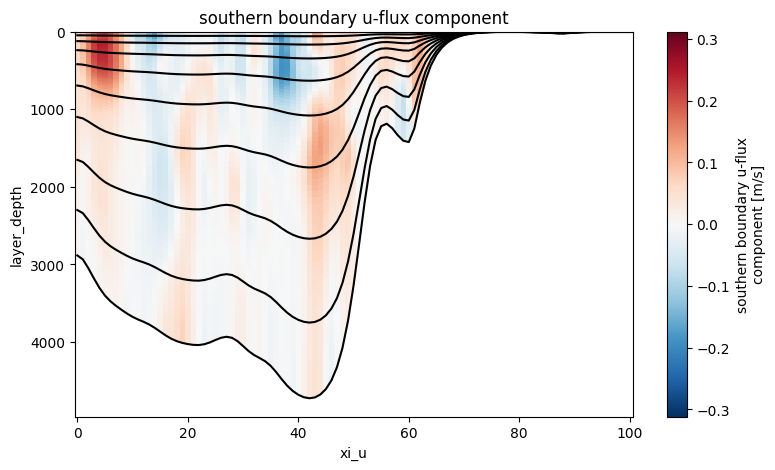

In [10]:
with ProgressBar():
    %time boundary_forcing.plot("u_south", time=0, layer_contours=True)

[########################################] | 100% Completed | 304.49 ms
CPU times: user 265 ms, sys: 137 ms, total: 403 ms
Wall time: 354 ms


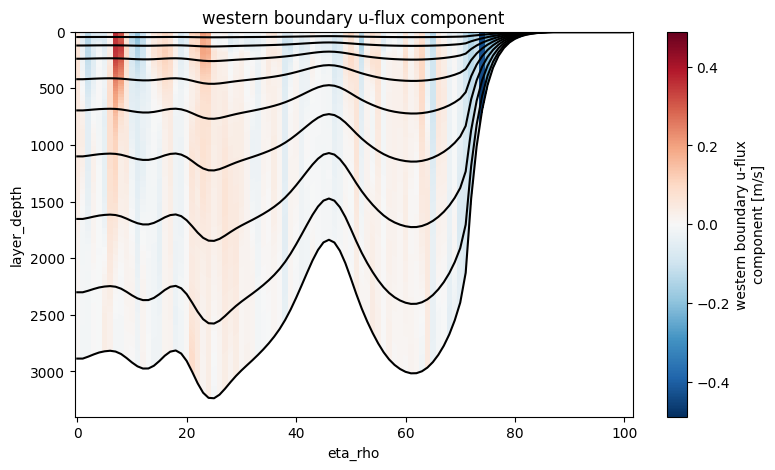

In [11]:
with ProgressBar():
    %time boundary_forcing.plot("u_west", time=0, layer_contours=True)

Sea surface height `zeta` at any of the boundaries and for a specific time is only a 1D variable.

[########################################] | 100% Completed | 102.45 ms
CPU times: user 25.7 ms, sys: 1.01 ms, total: 26.7 ms
Wall time: 130 ms


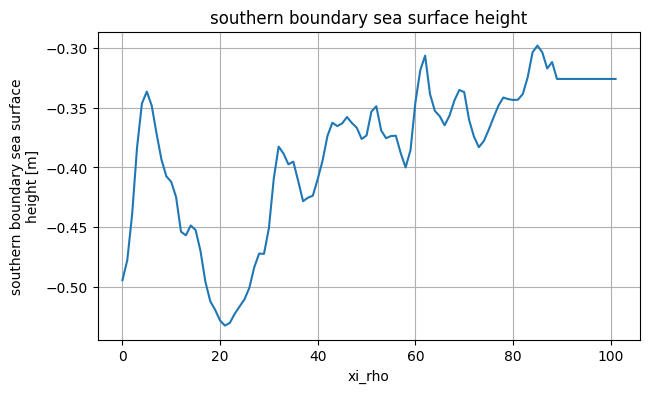

In [12]:
with ProgressBar():
    %time boundary_forcing.plot("zeta_south", time=0)

The same is true for the barotropic velocity `ubar`.

[########################################] | 100% Completed | 304.43 ms
CPU times: user 286 ms, sys: 121 ms, total: 407 ms
Wall time: 338 ms


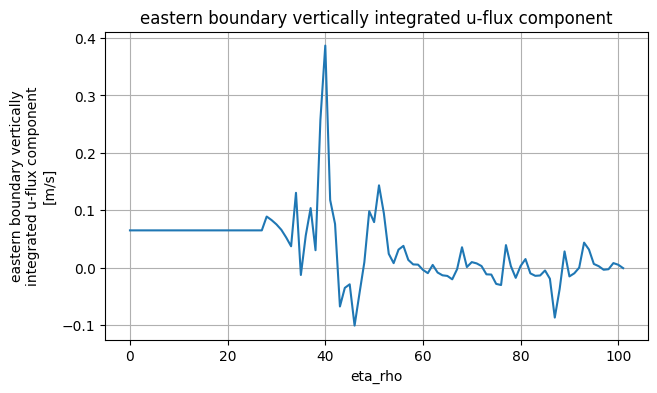

In [13]:
with ProgressBar():
    %time boundary_forcing.plot("ubar_east", time=0)

## Biogeochemical (BGC) boundary forcing
We now create BGC boundary forcing. The BGC variables are interpolated from a CESM climatology, which is located here.

In [14]:
cesm_path = "/global/cfs/projectdirs/m4746/Datasets/CESM_REGRIDDED/CESM-climatology_lowres_regridded.nc"

In [15]:
%%time

bgc_boundary_forcing = BoundaryForcing(
    grid=grid,
    start_time=start_time,
    end_time=end_time,
    boundaries={
        "south": True,
        "east": True,
        "north": True,
        "west": True,
    },  # this choice is the default
    source={"name": "CESM_REGRIDDED", "path": cesm_path, "climatology": True},
    type="bgc",
    use_dask=True,
)

CPU times: user 17.8 s, sys: 8.75 s, total: 26.5 s
Wall time: 49.4 s


In [16]:
bgc_boundary_forcing.ds

<xarray.Dataset> Size: 63MB
Dimensions:            (bry_time: 12, s_rho: 100, xi_rho: 102, eta_rho: 102)
Coordinates:
    abs_time           (bry_time) datetime64[ns] 96B 2000-01-16 ... 2000-12-15
  * bry_time           (bry_time) float64 96B 15.0 45.0 74.0 ... 319.0 349.0
Dimensions without coordinates: s_rho, xi_rho, eta_rho
Data variables: (12/128)
    PO4_south          (bry_time, s_rho, xi_rho) float32 490kB dask.array<chunksize=(12, 100, 102), meta=np.ndarray>
    NO3_south          (bry_time, s_rho, xi_rho) float32 490kB dask.array<chunksize=(12, 100, 102), meta=np.ndarray>
    SiO3_south         (bry_time, s_rho, xi_rho) float32 490kB dask.array<chunksize=(12, 100, 102), meta=np.ndarray>
    NH4_south          (bry_time, s_rho, xi_rho) float32 490kB dask.array<chunksize=(12, 100, 102), meta=np.ndarray>
    Fe_south           (bry_time, s_rho, xi_rho) float32 490kB dask.array<chunksize=(12, 100, 102), meta=np.ndarray>
    Lig_south          (bry_time, s_rho, xi_rho) float32 490kB dask.array<chunksize=(12, 100, 102), meta=np.ndarray>
    ...                 ...
    diazChl_west       (bry_time, s_rho, eta_rho) float32 490kB dask.array<chunksize=(12, 100, 102), meta=np.ndarray>
    diazC_west         (bry_time, s_rho, eta_rho) float32 490kB dask.array<chunksize=(12, 100, 102), meta=np.ndarray>
    diazP_west         (bry_time, s_rho, eta_rho) float32 490kB dask.array<chunksize=(12, 100, 102), meta=np.ndarray>
    diazFe_west        (bry_time, s_rho, eta_rho) float32 490kB dask.array<chunksize=(12, 100, 102), meta=np.ndarray>
    spCaCO3_west       (bry_time, s_rho, eta_rho) float32 490kB dask.array<chunksize=(12, 100, 102), meta=np.ndarray>
    zooC_west          (bry_time, s_rho, eta_rho) float32 490kB dask.array<chunksize=(12, 100, 102), meta=np.ndarray>
Attributes:
    title:                 ROMS boundary forcing file created by ROMS-Tools
    roms_tools_version:    0.1.dev138+dirty
    start_time:            2012-01-02 00:00:00
    end_time:              2012-01-04 00:00:00
    source:                CESM_REGRIDDED
    model_reference_date:  2000-01-01 00:00:00
    theta_s:               5.0
    theta_b:               2.0
    hc:                    300.0
    climatology:           True

In [17]:
bgc_boundary_forcing.ds["bry_time"]

<xarray.DataArray 'bry_time' (bry_time: 12)> Size: 96B
array([ 15.,  45.,  74., 105., 135., 166., 196., 227., 258., 288., 319., 349.])
Coordinates:
    abs_time  (bry_time) datetime64[ns] 96B 2000-01-16 2000-02-15 ... 2000-12-15
  * bry_time  (bry_time) float64 96B 15.0 45.0 74.0 105.0 ... 288.0 319.0 349.0
Attributes:
    long_name:     days since 2000-01-01 00:00:00
    units:         days
    cycle_length:  365.25

Note that `bgc_boundary_forcing.ds` has twelve time entries because the data in `source = {"name": "CESM_REGRIDDED", "path": bgc_path, "climatology": True}` is a climatology. 

For climatologies, `ROMS-Tools` does not subsample the twelve time entries further, regardless of the provided start and end time. Note that the `bry_time` coordinate has an additional attribute: `cycle_length` (with units in days). This attribute will tell ROMS to repeat the climatology every 365.25 days. In other words, the data in `bgc_boundary_forcing.ds` will work for ROMS run over any time window (as long as the model reference date is January 1, xxxx).

We can plot the BGC boundary forcing as we saw above.

[########################################] | 100% Completed | 403.64 ms
CPU times: user 106 ms, sys: 32.7 ms, total: 139 ms
Wall time: 455 ms


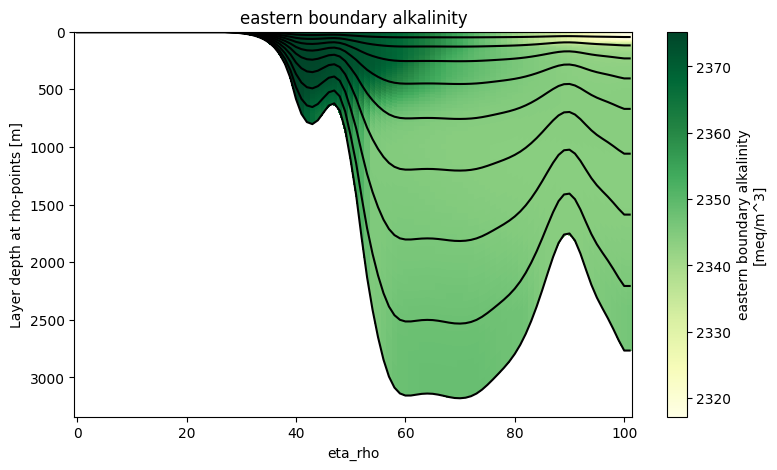

In [18]:
with ProgressBar():
    %time bgc_boundary_forcing.plot("ALK_east", time=0, layer_contours=True)

## Saving as NetCDF or YAML file
We can now save our boundary forcing as a NetCDF file. We need to specify a prefix for the desired target path.

In [19]:
filepath = "/pscratch/sd/n/nloose/forcing/my_boundary_forcing"

`ROMS-Tools` will group the boundary forcing by year and month and append the year and month information to this path. The files will be named with the format `filepath.YYYYMM.nc` if a full month of data is included (at least one data point per day), or `filepath.YYYYMMDD-DD.nc` otherwise.

In [20]:
with ProgressBar():
    %time boundary_forcing.save(filepath)

[########################################] | 100% Completed | 1.28 sms
CPU times: user 5.14 s, sys: 2.48 s, total: 7.62 s
Wall time: 1.5 s


We can also export the parameters of our `BoundaryForcing` object to a YAML file.

In [21]:
yaml_filepath = "/pscratch/sd/n/nloose/forcing/my_boundary_forcing.yaml"

In [22]:
boundary_forcing.to_yaml(yaml_filepath)

This is the YAML file that was created.

In [23]:
# Open and read the YAML file
with open(yaml_filepath, "r") as file:
    file_contents = file.read()

# Print the contents
print(file_contents)

---
roms_tools_version: 0.1.dev138+dirty
---
BoundaryForcing:
  boundaries:
    east: true
    north: true
    south: true
    west: true
  end_time: '2012-01-04T00:00:00'
  model_reference_date: '2000-01-01T00:00:00'
  source:
    climatology: false
    name: GLORYS
    path:
    - /global/cfs/projectdirs/m4746/Datasets/GLORYS/NA/2012/mercatorglorys12v1_gl12_mean_20120101.nc
    - /global/cfs/projectdirs/m4746/Datasets/GLORYS/NA/2012/mercatorglorys12v1_gl12_mean_20120102.nc
    - /global/cfs/projectdirs/m4746/Datasets/GLORYS/NA/2012/mercatorglorys12v1_gl12_mean_20120103.nc
    - /global/cfs/projectdirs/m4746/Datasets/GLORYS/NA/2012/mercatorglorys12v1_gl12_mean_20120104.nc
    - /global/cfs/projectdirs/m4746/Datasets/GLORYS/NA/2012/mercatorglorys12v1_gl12_mean_20120105.nc
  start_time: '2012-01-02T00:00:00'
  type: physics
Grid:
  N: 100
  center_lat: 61
  center_lon: -21
  hc: 300.0
  hmin: 5.0
  nx: 100
  ny: 100
  rot: 20
  size_x: 1800
  size_y: 2400
  theta_b: 2.0
  theta_s: 5.0
 

## Creating boundary forcing from an existing YAML file

In [24]:
%time the_same_boundary_forcing = BoundaryForcing.from_yaml(yaml_filepath, use_dask=True)

CPU times: user 7.09 s, sys: 2.28 s, total: 9.37 s
Wall time: 8.84 s


In [25]:
the_same_boundary_forcing.ds

<xarray.Dataset> Size: 3MB
Dimensions:     (bry_time: 4, s_rho: 100, xi_u: 101, xi_rho: 102, eta_rho: 102,
                 eta_v: 101)
Coordinates:
    abs_time    (bry_time) datetime64[ns] 32B 2012-01-01T12:00:00 ... 2012-01...
  * bry_time    (bry_time) float64 32B 4.384e+03 4.384e+03 4.386e+03 4.386e+03
Dimensions without coordinates: s_rho, xi_u, xi_rho, eta_rho, eta_v
Data variables: (12/28)
    u_south     (bry_time, s_rho, xi_u) float32 162kB dask.array<chunksize=(1, 100, 101), meta=np.ndarray>
    v_south     (bry_time, s_rho, xi_rho) float32 163kB dask.array<chunksize=(1, 100, 102), meta=np.ndarray>
    zeta_south  (bry_time, xi_rho) float32 2kB dask.array<chunksize=(1, 102), meta=np.ndarray>
    temp_south  (bry_time, s_rho, xi_rho) float32 163kB dask.array<chunksize=(1, 100, 102), meta=np.ndarray>
    salt_south  (bry_time, s_rho, xi_rho) float32 163kB dask.array<chunksize=(1, 100, 102), meta=np.ndarray>
    ubar_south  (bry_time, xi_u) float32 2kB dask.array<chunksize=(1, 101), meta=np.ndarray>
    ...          ...
    v_west      (bry_time, s_rho, eta_v) float32 162kB dask.array<chunksize=(1, 100, 101), meta=np.ndarray>
    zeta_west   (bry_time, eta_rho) float32 2kB dask.array<chunksize=(1, 102), meta=np.ndarray>
    temp_west   (bry_time, s_rho, eta_rho) float32 163kB dask.array<chunksize=(1, 100, 102), meta=np.ndarray>
    salt_west   (bry_time, s_rho, eta_rho) float32 163kB dask.array<chunksize=(1, 100, 102), meta=np.ndarray>
    ubar_west   (bry_time, eta_rho) float32 2kB dask.array<chunksize=(1, 102), meta=np.ndarray>
    vbar_west   (bry_time, eta_v) float32 2kB dask.array<chunksize=(1, 101), meta=np.ndarray>
Attributes:
    title:                 ROMS boundary forcing file created by ROMS-Tools
    roms_tools_version:    0.1.dev138+dirty
    start_time:            2012-01-02 00:00:00
    end_time:              2012-01-04 00:00:00
    source:                GLORYS
    model_reference_date:  2000-01-01 00:00:00
    theta_s:               5.0
    theta_b:               2.0
    hc:                    300.0

## 1D versus 2D horizontal fill

The horizontal fill process controls how ocean values are extended into land regions. This matters when the source data (such as GLORYS) and the ROMS grid have differing land masks, often due to different resolutions.
Without applying horizontal fill, land mask discrepancies could lead to NaN values at certain ocean points in the ROMS grid, where the source data (GLORYS) considers them land.

When creating the boundary forcing, users can select between two horizontal fill methods:

* **1D Horizontal Fill** (`apply_2d_horizontal_fill = False`): This method applies extrapolation along each boundary edge individually after regridding, using a [forward fill](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.ffill.html) followed by a [backward fill](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.bfill.html) to fill missing values.
* **2D Horizontal Fill** (`apply_2d_horizontal_fill = True`): This method fills missing values across the grid using a 2D diffusion AMG (Algebraic Multigrid) algorithm before the regridding step, allowing for more spatially smooth and consistent coverage across the entire area.

Note that the two methods coincide for boundaries that are entirely over open ocean (without any land interference).

<img src="images/horizontal_fill.png" alt="Horizontal fill" width="1000"/>

The **1D horizontal fill** method is **faster** and the **default** choice. The 2D horizontal fill, while more thorough, is slower as it fills an entire 2D domain at each depth level, often covering interior areas that won’t ultimately be used for the boundary forcing. For example, in the scenario above, the 2D fill would extend values across both Iceland and Greenland. 

<div class="alert alert-info">

Note

To minimize unnecessary calculations, `ROMS-Tools` limits the 2D fill to a small area surrounding the target ROMS domain, so it wouldn't fill the entire North Atlantic in the scenario above. However, a buffer zone around the target ROMS domain is included to avoid edge artifacts from the 2D fill near the boundaries.
    
</div>

However, there are certain **limitations with the 1D fill approach**:

* **Entire Boundaries on Land:** When an entire boundary edge lies on land (as with the northern edge in the example), the 1D fill method applies a simple constant fill value (zero), while the 2D fill method generates more nuanced values based on its spatial diffusion algorithm. However, boundaries entirely on land are not required for boundary forcing and can be deselected in the boundary forcing generation to save computational resources and simplify the setup.
* **Islands in Boundaries:** When a large island (or peninsula) sits within a boundary region, the 1D forward fill can create unwanted effects, such as spreading values from one side of the island to the other.

Let's look at an example to understand differences between the 1D fill and 2D fill approach better.

In [26]:
grid = Grid(
    nx=100, ny=100, size_x=1000, size_y=1000, center_lon=-31, center_lat=64, rot=25
)

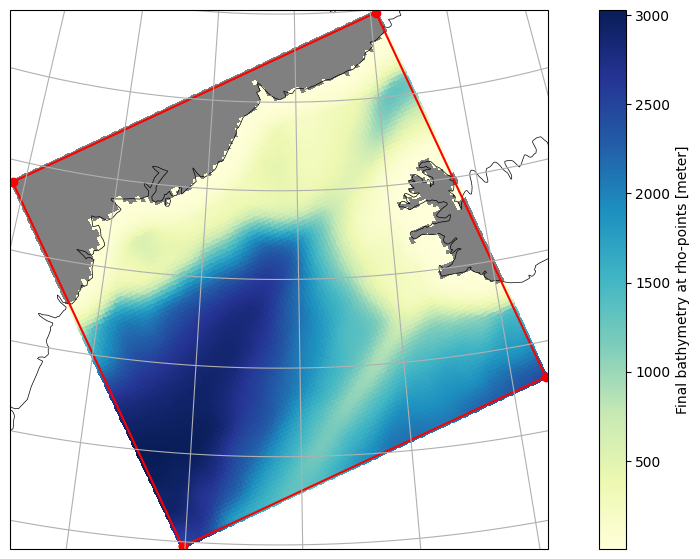

In [27]:
grid.plot(bathymetry=True)

We now create the boundary forcing twice, once with a 1D horizontal fill, and once with a 2D horizontal fill. By choosing `use_dask = False`, we trigger computation upon creating these two objects, and we can get a comparison of the timings.

In [28]:
%%time

boundary_forcing_with_1d_fill = BoundaryForcing(
    grid=grid,
    start_time=start_time,
    end_time=end_time,
    boundaries={
        "south": True,
        "east": True,
        "north": True,
        "west": True,
    },
    source={"name": "GLORYS", "path": glorys_path},
    apply_2d_horizontal_fill=False,  # default is False
    use_dask=False,
)

CPU times: user 2.74 s, sys: 1.24 s, total: 3.98 s
Wall time: 4.61 s


/global/u2/n/nloose/roms-tools/roms_tools/setup/boundary_forcing.py:641: UserWarning: NaN values detected in regridded variables along the northern boundary. This may indicate that the entire boundary is on land in the source data, or that the source data does not cover this boundary.
  warnings.warn(


In [29]:
%%time

boundary_forcing_with_2d_fill = BoundaryForcing(
    grid=grid,
    start_time=start_time,
    end_time=end_time,
    boundaries={
        "south": True,
        "east": True,
        "north": True,
        "west": True,
    },
    source={"name": "GLORYS", "path": glorys_path},
    apply_2d_horizontal_fill=True,  # default is False
    use_dask=False,
)

CPU times: user 22min 39s, sys: 1.21 s, total: 22min 40s
Wall time: 15.8 s


Creating the boundary forcing with a 2D horizontal fill took about 3 times as long as with the 1D horizontal fill. 

<div class="alert alert-info">

Note
    
In this example, the northern boundary is entirely over land, which means it could have been excluded from the boundary generation by setting `boundaries = {"south": True, "east": True, "north": False, "west": True}`. However, we kept the northern boundary in this demonstration to illustrate the `ROMS-Tools` behavior when an entire boundary edge lies over land.

</div>

Let's compare the results! As an example, we will look at temperature along the four boundaries at the first time step.

In [30]:
import matplotlib.pyplot as plt

bdry_coords = {
    "south": {"eta_rho": 0},
    "east": {"xi_rho": -1},
    "north": {"eta_rho": -1},
    "west": {"xi_rho": 0},
}


def compare_fill_methods(direction, bry_time=0):

    fig, axs = plt.subplots(1, 3, figsize=(15, 3))

    var_name = "temp"
    kwargs = {"cbar_kwargs": {"label": "degrees Celsius"}}

    mask = grid.ds.mask_rho.isel(**bdry_coords[direction])

    boundary_forcing_with_2d_fill.ds[f"{var_name}_{direction}"].isel(
        bry_time=bry_time
    ).plot(ax=axs[0], **kwargs)
    axs[0].set_title("2D horizontal fill")
    boundary_forcing_with_1d_fill.ds[f"{var_name}_{direction}"].isel(
        bry_time=bry_time
    ).plot(ax=axs[1], **kwargs)
    axs[1].set_title("1D horizontal fill")
    (boundary_forcing_with_2d_fill.ds - boundary_forcing_with_1d_fill.ds)[
        f"{var_name}_{direction}"
    ].where(mask).isel(bry_time=bry_time).plot(ax=axs[2], **kwargs)
    axs[2].set_title("Difference at wet points")

    fig.suptitle(f"Temperature at {direction}ern boundary", y=1.05)

    return fig

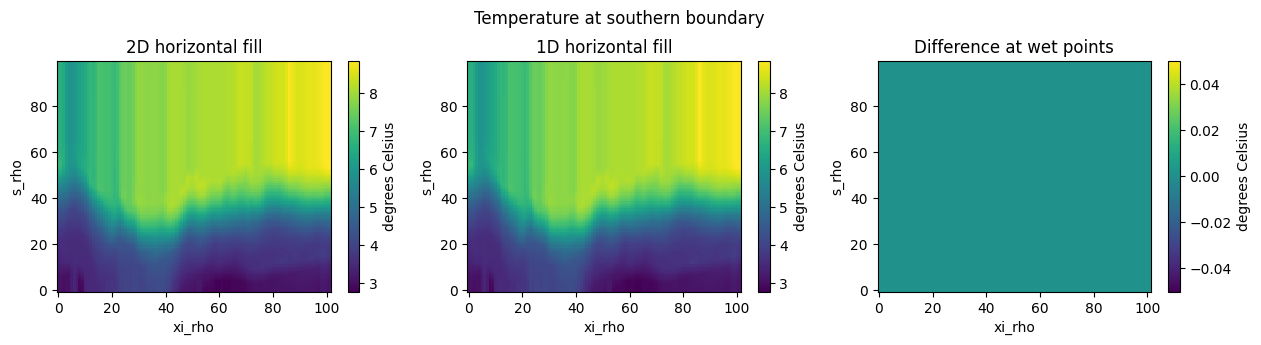

In [31]:
fig = compare_fill_methods("south")

The southern boundary does not contain any land points, so southern boundary temperature is the same for both fill methods, as expected.

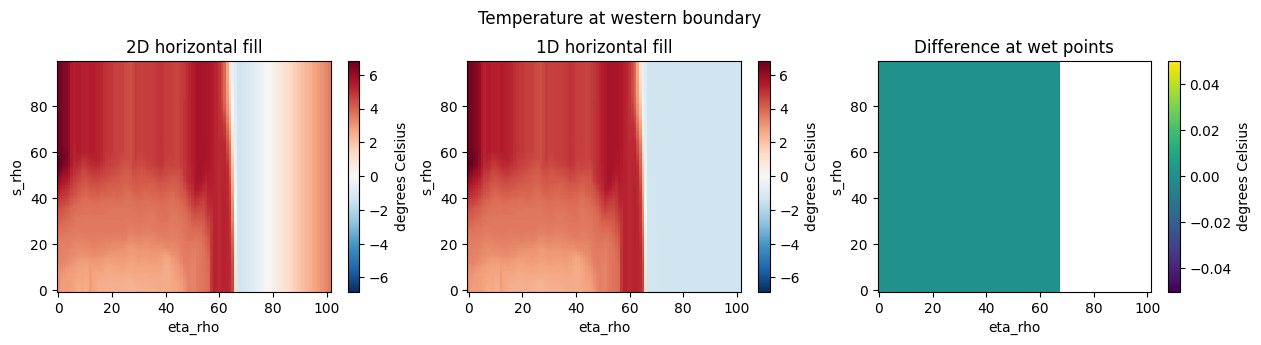

In [32]:
fig = compare_fill_methods("west")

The western boundary intersects Greenland (for `eta_rho` > 67), and the fill values differ over Greenland between the two fill methods. However, for this particular example, the values coincide at wet points (i.e., for `eta_rho` <= 67). Thus, the choice between fill methods does not affect the ROMS online simulation outcome in this example.

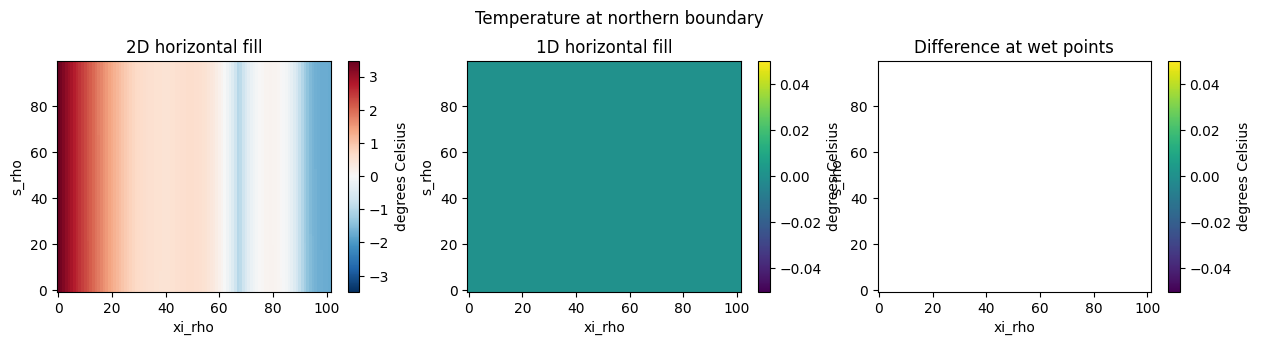

In [33]:
fig = compare_fill_methods("north")

The northern boundary lies entirely over land (Greenland), and might as well have been skipped in the boundary forcing generation. The fill values generated by the 2D fill are more sophisticated than those by the 1D fill (simply zero). But this won't have any influence on the online model.

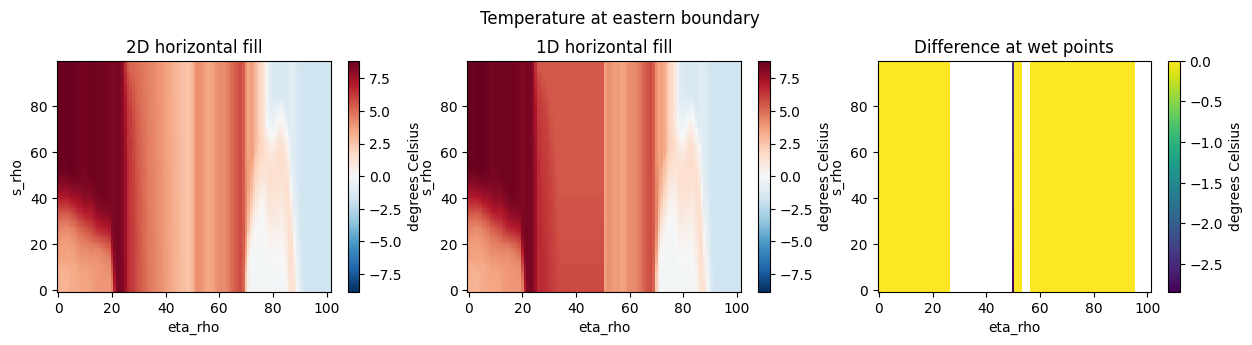

In [34]:
fig = compare_fill_methods("east")

The western boundary is interrupted by Iceland, highlighting one of the limitations of the 1D fill method. As noted earlier, the 1D fill applied a straightforward forward fill, which inadvertently spread values from the region south of Iceland to the region north of Iceland, creating an artifact in the eastern boundary data north of Iceland (at about `eta_rho` = 50).

<div class="alert alert-info">

Summary
  
The default 1D horizontal fill is a fast and typically reliable option, except in situations where land segments divide a boundary section. In these cases, the 2D fill method is the safer option because the 1D fill may extend values across the land from one side to the other, potentially introducing unintended effects.
    
</div>